# drawing-hares-v2
neatened version of notebook `drawing-hares.ipynb`

In [1]:
# stock imports
import pickle
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import scipy
import os

##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

from scripts import prior_funcs, utils

# plt.style.use('dark_background')
plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

#script imports
from scripts import prior_funcs, utils

from scripts.pitchfuncs_ultra_pca_v2 import emulator
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_vector_surface
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_popslice
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_popwalk

2024-10-17 10:54:42.887365: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 10:54:42.898410: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 10:54:42.901813: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 10:54:42.910506: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-17 10:54:43.524654: W tensorflow/compiler/tf2

## define priors
start off by defining some priors that we'll use to inform sampling of hare parameters. priors should:
- be bounded to the edges of the model grid to avoid neural network extrapolation (beta distributions are our friends here)
- be (roughly) the same as ones we'll use later in sampling

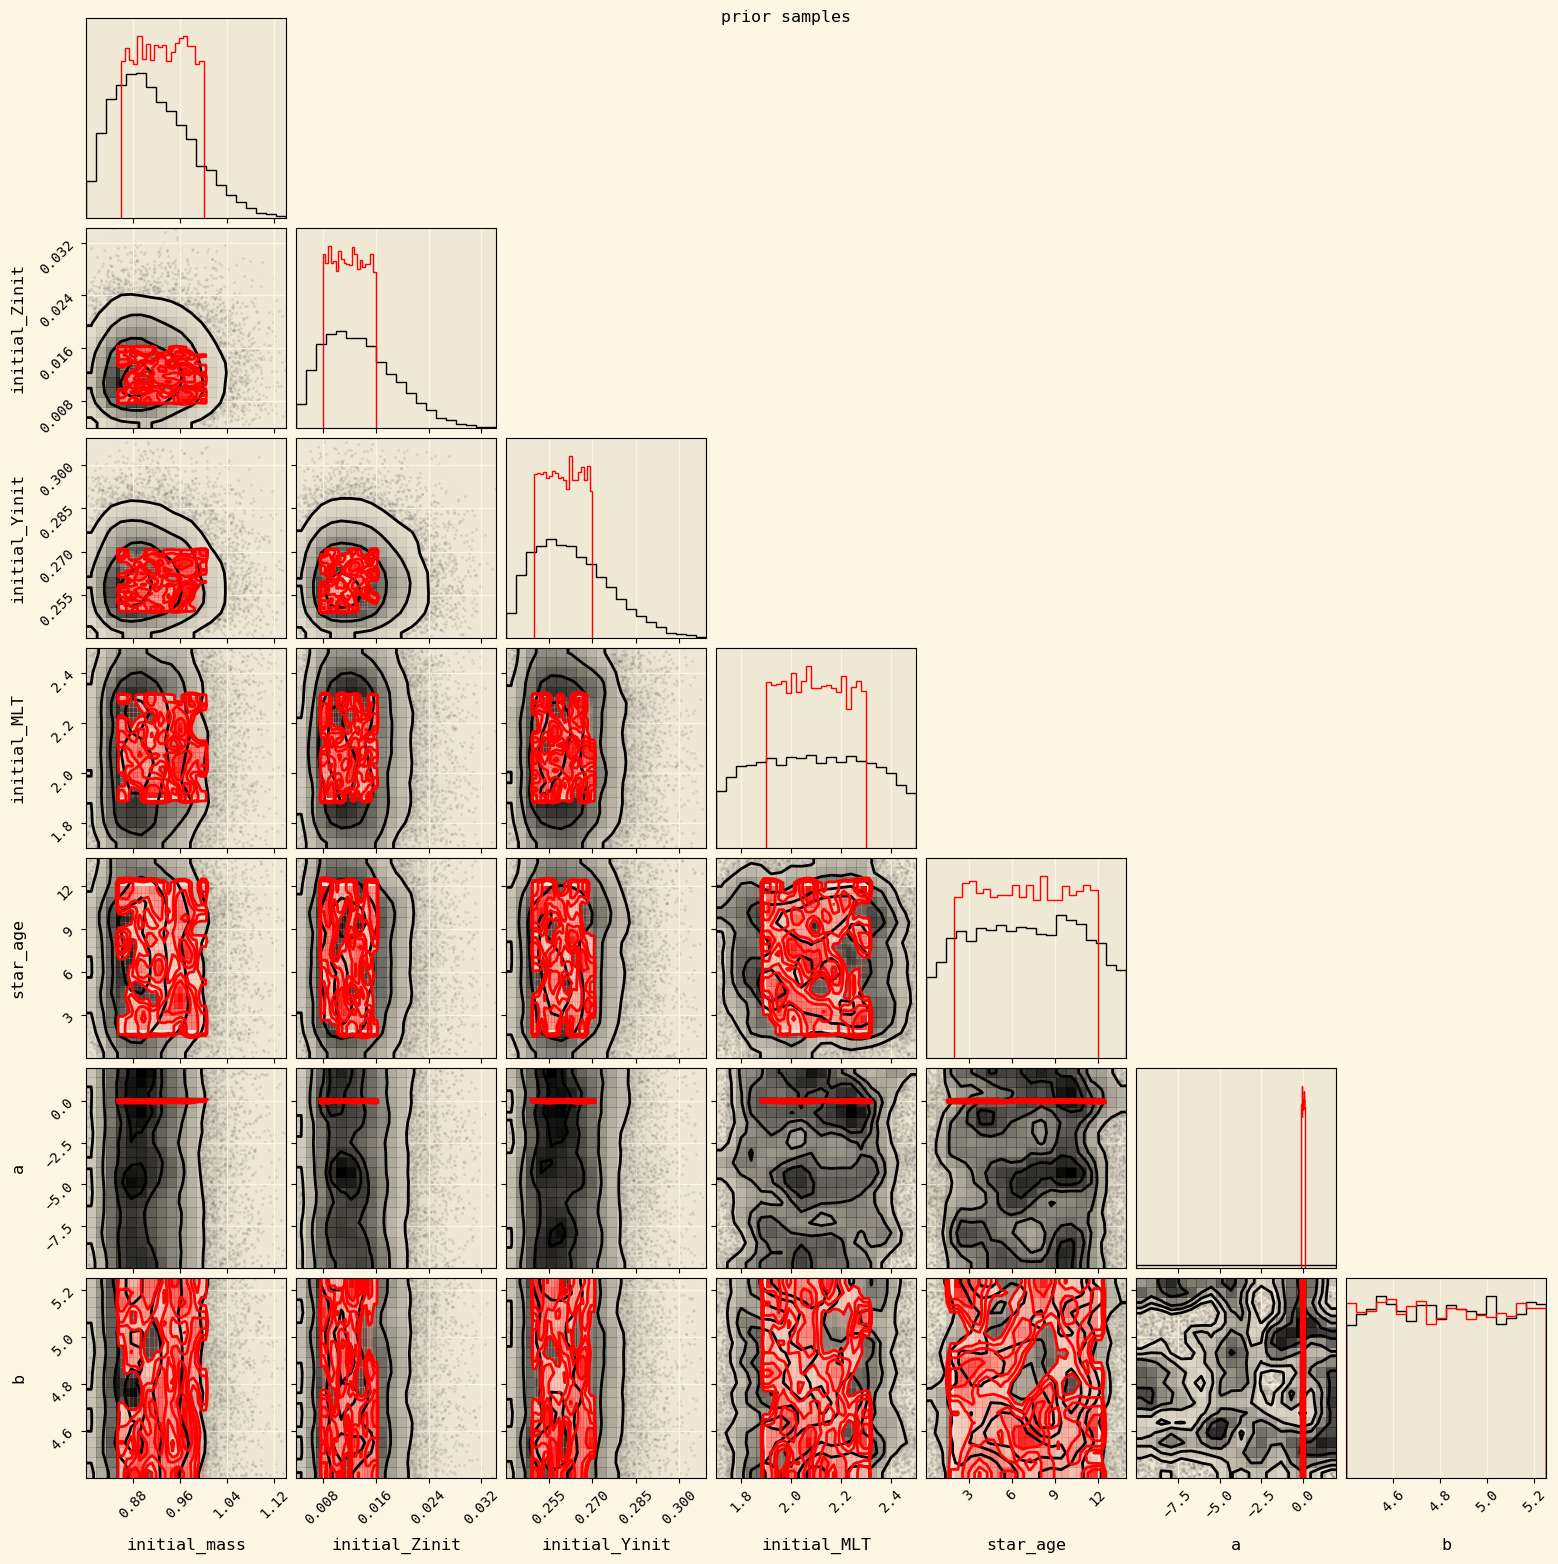

In [8]:
labels = ["initial_mass", "initial_Zinit", "initial_Yinit", "initial_MLT", "star_age", "a", "b"]

mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=2, b=5)

Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)

Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)

MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=1.2, b=1.2)

a_prior = prior_funcs.custom_uniform_prior(-10, 2)

b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)


priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

mass_prior = prior_funcs.custom_uniform_prior(0.86, 1)

Zinit_prior = prior_funcs.custom_uniform_prior(0.008, 0.016)

Yinit_prior = prior_funcs.custom_uniform_prior(0.25, 0.27)

MLT_prior = prior_funcs.custom_uniform_prior(1.9, 2.3)

age_prior = prior_funcs.custom_uniform_prior(2, 12)

a_prior = prior_funcs.custom_uniform_prior(-0.1, 0.1)

b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)

hare_draws = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

size = 10000
plot_prior_samples = np.array([prior.rvs(size=size) for prior in priors])
legend_labels = []
corner_color = "black"
figure = corner.corner(
    plot_prior_samples.T,
    labels=labels,
    color=corner_color,
    hist_kwargs={"density": True},
    smooth=True,
)

plot_hare_draw_samples = np.array([hare_draw.rvs(size=size) for hare_draw in hare_draws])
corner.corner(
    plot_hare_draw_samples.T,
    labels=labels,
    color="red",
    fig=figure,
    hist_kwargs={"density": True},
    smooth=True,
)

plt.suptitle("prior samples")
plt.show()

## import grid
now we'll import the grid of stellar models to use when we draw hares

In [9]:
df_full = pd.concat(
    [
        pd.read_hdf(
            "/home/oxs235/datastorage/repos_data/ojscutt/mesa_ajl/data/grid2p5a/grid.h5",
            key=f"m{0.8 + i*0.02:.2f}",
        )
        for i in range(21)
    ],
    ignore_index=True,
)
df = df_full[df_full["log_g"] >= 3.6]
df = df[df["star_age"] <= 14]
df = df[df["frac_age"] >= 0.015]

inputs = ["initial_mass", "initial_Zinit", "initial_Yinit", "initial_MLT", "star_age"]
outputs = (
    ["radius", "luminosity", "star_feh"]
    + [f"nu_0_{i}" for i in range(6, 41)]
    + ["nu_max"]
)

df = df.loc[(df[[f"nu_0_{i}" for i in range(6, 41)]] != 0).all(axis=1)]

cols = inputs + outputs

df = df[cols]

df.dropna(inplace=True)

df["calc_effective_T"] = utils.calc_Teff(df["luminosity"], df["radius"])

In [10]:
df.describe()

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,star_feh,nu_0_6,nu_0_7,...,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,nu_max,calc_effective_T
count,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,...,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06
mean,1.021885e+00,1.440698e-02,2.814693e-01,2.117984e+00,5.000177e+00,1.312728e+00,2.116482e+00,-1.127145e-01,7.726572e+02,8.860424e+02,...,3.696535e+03,3.802234e+03,3.907317e+03,4.011806e+03,4.115788e+03,4.219425e+03,4.322952e+03,4.426627e+03,2.370506e+03,5.866797e+03
std,1.175610e-01,9.677123e-03,2.805593e-02,2.879175e-01,3.405371e+00,4.813547e-01,1.572419e+00,3.499532e-01,2.959808e+02,3.426600e+02,...,1.451591e+03,1.494205e+03,1.536228e+03,1.577500e+03,1.617908e+03,1.657417e+03,1.696104e+03,1.734156e+03,1.156533e+03,5.670330e+02
min,8.000000e-01,3.869061e-03,2.400000e-01,1.700000e+00,2.966411e-02,6.990236e-01,1.321735e-01,-1.077903e+00,2.103102e+02,2.385545e+02,...,1.002125e+03,1.032723e+03,1.063221e+03,1.093511e+03,1.123625e+03,1.153506e+03,1.183191e+03,1.212653e+03,4.317504e+02,4.096930e+03
25%,9.200000e-01,6.471429e-03,2.600000e-01,1.900000e+00,2.309880e+00,9.719693e-01,9.371542e-01,-4.000000e-01,5.476978e+02,6.234189e+02,...,2.578850e+03,2.649156e+03,2.720741e+03,2.793748e+03,2.868279e+03,2.944027e+03,3.020312e+03,3.097018e+03,1.444480e+03,5.491841e+03
50%,1.040000e+00,1.077191e-02,2.800000e-01,2.100000e+00,4.275231e+00,1.160016e+00,1.698469e+00,-1.000000e-01,7.832912e+02,8.972267e+02,...,3.760636e+03,3.866328e+03,3.970106e+03,4.072429e+03,4.174203e+03,4.276548e+03,4.380549e+03,4.486487e+03,2.352665e+03,5.859776e+03
75%,1.120000e+00,2.007835e-02,3.000000e-01,2.300000e+00,7.159688e+00,1.498369e+00,2.883064e+00,1.837200e-01,9.935144e+02,1.142381e+03,...,4.784137e+03,4.922458e+03,5.059497e+03,5.194580e+03,5.327444e+03,5.458355e+03,5.587658e+03,5.716681e+03,3.185873e+03,6.219454e+03
max,1.200000e+00,3.897971e-02,3.200000e-01,2.500000e+00,1.399997e+01,2.873431e+00,1.163902e+01,5.094573e-01,1.480807e+03,1.705344e+03,...,7.145063e+03,7.354126e+03,7.562945e+03,7.771521e+03,7.979340e+03,8.185512e+03,8.382538e+03,8.584072e+03,5.856447e+03,7.993034e+03


## draw hares
here's where we use our priors to inform nearest-neighbour sampling of hares from the imported grid

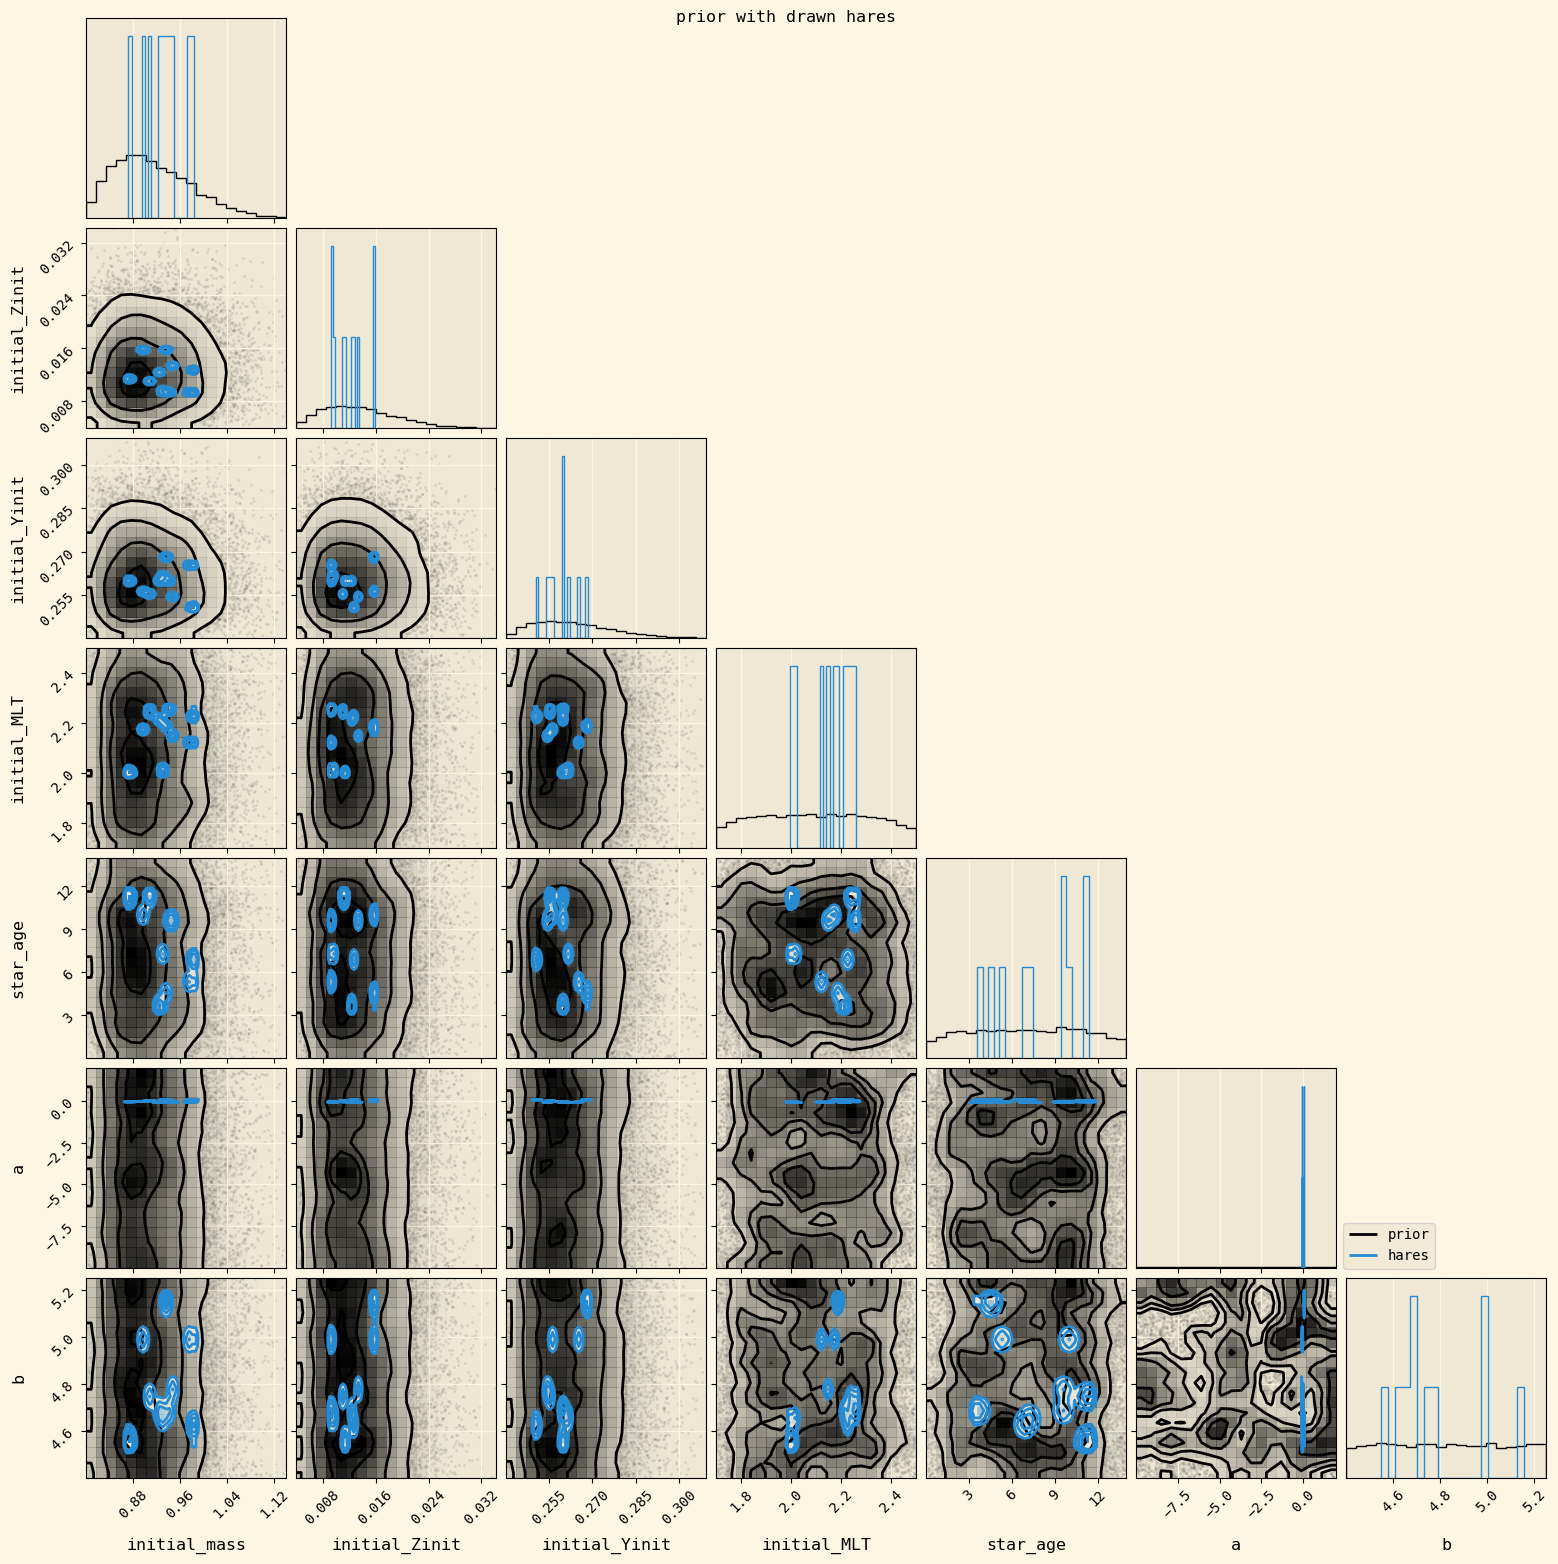

In [11]:
hares_to_sample = 10


prior_samples = np.array([hare_draw.rvs(size=hares_to_sample) for hare_draw in hare_draws])


def corner_legend(color, label):
    return [
        Line2D(
            [0],
            [0],
            marker="",
            color=color,
            markerfacecolor=color,
            markersize=10,
            label=label,
        )
    ]


# plotting samples over priors:
legend_labels = []

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

priors_color = "black"
figure = corner.corner(
    plot_prior_samples.T,
    labels=labels,
    color=priors_color,
    hist_kwargs={"density": True},
    smooth=True,
)
legend_labels += corner_legend(priors_color, "prior")

hares_color = colors[0]
corner.corner(
    prior_samples.T,
    labels=labels,
    color=hares_color,
    hist_kwargs={"density": True},
    fig=figure,
    smooth=True,
)
legend_labels += corner_legend(hares_color, "hares")

plt.legend(handles=legend_labels, bbox_to_anchor=(0, 1, 0.48, 0.31))
plt.suptitle("prior with drawn hares")
plt.show()

In [13]:
from scipy.spatial.distance import cdist
import os


def closest_grid_point(
    point,
    grid_df,
    a,
    b,
    columns=[
        "initial_mass",
        "initial_Zinit",
        "initial_Yinit",
        "initial_MLT",
        "star_age",
    ],
):

    closest_point = grid_df.iloc[[cdist([point], grid_df[columns].values).argmin()]].copy()

    closest_point['a'] = a
    closest_point['b'] = b
    
    return closest_point


def nu_max_n(hare_sample):
    nu_max = hare_sample["nu_max"]
    nu_max_header = (
        np.abs(hare_sample[[f"nu_0_{i}" for i in range(6, 41)]] - nu_max.values[0])
        .min()
        .idxmin()
    )
    hare_sample_new = hare_sample.copy()
    hare_sample_new.loc[:, "nu_max_n"] = nu_max_header.replace("nu_0_", "")
    return hare_sample_new


for hare_idx in range(hares_to_sample):
    hare_sample = closest_grid_point(prior_samples[:5, hare_idx], df, 0, 4.8)
    hare_sample = nu_max_n(hare_sample)
    path = f"form/hare{hare_idx}"
    if not os.path.exists(path):
        os.mkdir(path)
        print(f"{path} created!")
    else:
        print(f"{path} already exists", end="\r")
    hare_sample.to_json(path + f"/hare{hare_idx}.json")

form/hare0 created!
form/hare1 created!
form/hare2 created!
form/hare3 created!
form/hare4 created!
form/hare5 created!
form/hare6 created!
form/hare7 created!
form/hare8 created!
form/hare9 created!
